# Generating Arabic Names with a Character-Level Neural Network


This notebook demonstrates the process of generating plausible Arabic names using a character-level neural network model implemented in PyTorch.
We will train a simple model on a combined list of common Arabic male and female first names to learn the patterns of character sequences.
The goal is to generate new names that resemble the structure and style of authentic Arabic names found in the training data.

### 1. Data Preparation

First, we need to load our dataset of Arabic names. We'll read names from two separate files, one for male names and one for female names, and combine them into a single list. We will also perform basic cleaning like removing duplicates and empty strings.

In [6]:
from google.colab import files
uploaded = files.upload()

# Get the actual file names from the upload dictionary
male_file = 'male_arabic_names.txt'
female_file = 'female_arabic_names.txt'

# Function to read names from a file
def load_names(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            names = f.read().splitlines()
        names = [name.strip() for name in names if name.strip()]
        return names
    except FileNotFoundError:
        print(f"Error: File not found at {filename}")
        return []

# Now pass file names, not contents
male_names = load_names(male_file)
female_names = load_names(female_file)


Saving female_arabic_names.txt to female_arabic_names (2).txt
Saving male_arabic_names.txt to male_arabic_names (2).txt


In [7]:
# Import necessary libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for plotting
import random


# Combine the lists
arabic_names = male_names + female_names

# Remove duplicates and ensure uniqueness
arabic_names = sorted(list(set(arabic_names)))

# Shuffle the dataset for good measure
random.shuffle(arabic_names)

if arabic_names: # Proceed only if names were loaded
    print(f'Loaded {len(male_names)} male names.')
    print(f'Loaded {len(female_names)} female names.')
    print(f'Total unique names: {len(arabic_names)}')
    print('First 10 names in the combined list:')
    print(arabic_names[:10])
else:
    print('No names loaded. Please check file paths and content.')

Loaded 223 male names.
Loaded 230 female names.
Total unique names: 452
First 10 names in the combined list:
['ياسر', 'ناصر', 'ممدوح', 'رشا', 'بيان', 'سارة', 'حمدان', 'نعمان', 'تحفة', 'مأمون']


### 2. Dataset Exploration

Let's look at some basic statistics of our combined dataset, such as the number of names, and the shortest and longest names.

In [8]:
# Calculate basic statistics only if names are loaded
if arabic_names:
    num_names = len(arabic_names)
    min_len = min(len(w) for w in arabic_names)
    max_len = max(len(w) for w in arabic_names)

    print(f'Number of names: {num_names}')
    print(f'Shortest name length: {min_len}')
    print(f'Longest name length: {max_len}')
else:
    print('Cannot calculate statistics as no names were loaded.')

Number of names: 452
Shortest name length: 2
Longest name length: 10


### 3. Bigram Analysis (Optional)

While our model will learn patterns directly, looking at bigrams (pairs of adjacent characters) can give us insights into the data. We count how often each character follows another, including special start (`<S>`) and end (`<E>`) tokens.

In [9]:
# Dictionary to store bigram counts
bigram_counts = {}

# Iterate through each name if available
if arabic_names:
    for name in arabic_names:
      # Add start and end tokens
      chars = ['<S>'] + list(name) + ['<E>']
      # Create bigrams and count them
      for ch1, ch2 in zip(chars, chars[1:]):
        bigram = (ch1, ch2)
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1

    # Sort bigrams by frequency (most common first)
    sorted_bigrams = sorted(bigram_counts.items(), key=lambda kv: -kv[1])

    # Display the top 20 most frequent bigrams
    print("Top 20 most frequent bigrams:")
    print(sorted_bigrams[:20])
else:
    print('Cannot perform bigram analysis as no names were loaded.')

Top 20 most frequent bigrams:
[(('ة', '<E>'), 96), (('<S>', 'ب'), 53), (('ن', '<E>'), 48), (('ر', '<E>'), 42), (('<S>', 'أ'), 42), (('ا', 'ن'), 41), (('د', '<E>'), 39), (('<S>', 'ح'), 38), (('ي', '<E>'), 37), (('<S>', 'م'), 36), (('ل', '<E>'), 31), (('م', '<E>'), 31), (('<S>', 'ر'), 30), (('ا', 'ل'), 28), (('<S>', 'ت'), 27), (('ي', 'ة'), 26), (('ر', 'ا'), 26), (('ا', 'م'), 26), (('ا', 'ء'), 25), (('ء', '<E>'), 24)]


### 4. Preparing Data for PyTorch

We need to convert our names into numerical representations that PyTorch can understand. We'll create mappings from characters to integers (`stoi`) and vice-versa (`itos`). We also define a special character `'.'` to represent both start and end, simplifying the input structure for the neural network.

In [11]:
# Initialize variables to avoid potential errors if names are not loaded
stoi = {}
itos = {}
vocab_size = 0
X_train, Y_train = torch.tensor([]), torch.tensor([])

if arabic_names:
    # Get all unique characters in the dataset
    chars = sorted(list(set(''.join(arabic_names))))

    # Create character-to-integer and integer-to-character mappings
    # Add a special '.' token for start/end
    stoi = {s: i + 1 for i, s in enumerate(chars)}
    stoi['.'] = 0  # Use '.' for both <S> and <E> mapping
    itos = {i: s for s, i in stoi.items()}

    vocab_size = len(itos)

    print(f'Vocabulary size: {vocab_size}')
    print(f'Character to index mapping (stoi): {stoi}')
    print(f'Index to character mapping (itos): {itos}')

    # Build the dataset of input (character) -> target (next character)
    def build_dataset(names):
        X, Y = [], [] # X = input character index, Y = target character index
        for w in names:
            context = [0] # Start with the '.' token index
            for ch in w + '.': # Append '.' to represent the end
                ix = stoi[ch]
                X.append(context[0]) # Input is the single preceding character
                Y.append(ix)       # Target is the current character
                context = [ix] # Update context (not really needed for bigram, but good practice)
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        print(f'Dataset shape: X={X.shape}, Y={Y.shape}')
        return X, Y

    # Create training set
    X_train, Y_train = build_dataset(arabic_names)
else:
    print('Cannot prepare data for PyTorch as no names were loaded.')

Vocabulary size: 38
Character to index mapping (stoi): {' ': 1, 'ء': 2, 'آ': 3, 'أ': 4, 'ؤ': 5, 'إ': 6, 'ئ': 7, 'ا': 8, 'ب': 9, 'ة': 10, 'ت': 11, 'ث': 12, 'ج': 13, 'ح': 14, 'خ': 15, 'د': 16, 'ذ': 17, 'ر': 18, 'ز': 19, 'س': 20, 'ش': 21, 'ص': 22, 'ض': 23, 'ط': 24, 'ظ': 25, 'ع': 26, 'غ': 27, 'ف': 28, 'ق': 29, 'ك': 30, 'ل': 31, 'م': 32, 'ن': 33, 'ه': 34, 'و': 35, 'ى': 36, 'ي': 37, '.': 0}
Index to character mapping (itos): {1: ' ', 2: 'ء', 3: 'آ', 4: 'أ', 5: 'ؤ', 6: 'إ', 7: 'ئ', 8: 'ا', 9: 'ب', 10: 'ة', 11: 'ت', 12: 'ث', 13: 'ج', 14: 'ح', 15: 'خ', 16: 'د', 17: 'ذ', 18: 'ر', 19: 'ز', 20: 'س', 21: 'ش', 22: 'ص', 23: 'ض', 24: 'ط', 25: 'ظ', 26: 'ع', 27: 'غ', 28: 'ف', 29: 'ق', 30: 'ك', 31: 'ل', 32: 'م', 33: 'ن', 34: 'ه', 35: 'و', 36: 'ى', 37: 'ي', 0: '.'}
Dataset shape: X=torch.Size([2432]), Y=torch.Size([2432])


### 5. Neural Network Model Definition

We define a simple neural network using PyTorch's `nn.Module`. This model consists of:
1. An Embedding layer: Converts character indices into dense vectors.
2. A Linear layer: Maps the embedding vector to logits representing the probability distribution over the next possible character.

In [12]:
# Define the neural network model
class BigramModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim=10): # Using a small embedding dimension
        super().__init__()
        # Embedding layer: maps character index to a vector
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        # Linear layer: maps embedding vector to output logits
        self.linear = torch.nn.Linear(embedding_dim, vocab_size)

    def forward(self, idx):
        # Get embeddings for the input character indices
        emb = self.embedding(idx)
        # Pass embeddings through the linear layer to get logits
        logits = self.linear(emb)
        return logits

# Initialize the model only if vocab_size is valid
model = None
if vocab_size > 0:
    embedding_dimension = 20 # Can be tuned
    model = BigramModel(vocab_size, embedding_dim=embedding_dimension)
    print(f'Model initialized with {sum(p.numel() for p in model.parameters())} parameters.')
else:
    print('Model cannot be initialized as vocabulary size is zero.')

Model initialized with 1558 parameters.


### 6. Model Training

Now we train the model using the dataset we prepared. We use the Adam optimizer and Cross-Entropy Loss. We'll train for a number of epochs, periodically evaluating and printing the loss.

Starting training for 500 epochs...
Epoch 50/500, Loss: 2.4886
Epoch 100/500, Loss: 2.5001
Epoch 150/500, Loss: 2.4679
Epoch 200/500, Loss: 2.6309
Epoch 250/500, Loss: 2.8273
Epoch 300/500, Loss: 2.6589
Epoch 350/500, Loss: 2.5376
Epoch 400/500, Loss: 2.5998
Epoch 450/500, Loss: 2.5078
Epoch 500/500, Loss: 2.6612
Training finished.


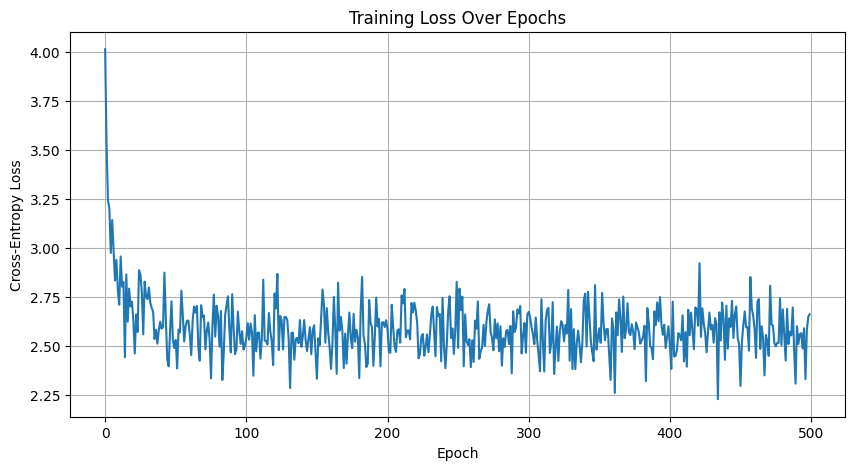

In [14]:
# Training parameters
learning_rate = 0.1 # Adjusted learning rate
num_epochs = 500    # Increased epochs for potentially better convergence
batch_size = 128    # Process data in batches
report_interval = 50 # How often to print loss

# List to store loss values for plotting
losses = []

# Proceed with training only if model and data are ready
if model and X_train.nelement() > 0:
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    print(f'Starting training for {num_epochs} epochs...')

    for epoch in range(num_epochs):
        # Create mini-batches
        ix = torch.randint(0, X_train.shape[0], (batch_size,))
        Xb, Yb = X_train[ix], Y_train[ix] # Batch X, Y

        # Forward pass
        logits = model(Xb)

        # Calculate loss (CrossEntropyLoss expects logits)
        loss = F.cross_entropy(logits, Yb)

        # Backward pass and optimization
        optimizer.zero_grad() # Zero gradients
        loss.backward()     # Compute gradients
        optimizer.step()      # Update parameters

        # Track loss
        losses.append(loss.item())

        # Print progress
        if (epoch + 1) % report_interval == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

    print('Training finished.')

    # Plot the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.grid(True)
    plt.show()
else:
    print('Training cannot start. Check if data was loaded and model was initialized.')

### 7. Generating New Names

With the trained model, we can now generate new Arabic names. We start with the special start token `'.'` and iteratively predict the next character based on the model's output probabilities until the end token `'.'` is generated.

In [19]:
# Function to generate names
def generate_name(model, itos, stoi, max_len=20):
    if not model or not itos or not stoi:
        print("Cannot generate name. Model or mappings not available.")
        return ""

    model.eval() # Set model to evaluation mode
    name_chars = []
    context_idx = stoi['.'] # Start with the '.' token index

    with torch.no_grad(): # No need to track gradients during generation
        for _ in range(max_len):
            # Prepare input tensor (add batch dimension)
            input_tensor = torch.tensor([context_idx])

            # Forward pass to get logits
            logits = model(input_tensor)

            # Convert logits to probabilities using softmax
            probs = F.softmax(logits, dim=1)

            # Sample the next character index based on probabilities
            next_idx = torch.multinomial(probs, num_samples=1).item()

            # Check if the end token is generated
            if next_idx == stoi['.']:
                break

            # Append the generated character
            name_chars.append(itos[next_idx])

            # Update the context for the next iteration
            context_idx = next_idx

    model.train() # Set model back to training mode
    return ''.join(name_chars)

# Generate some names if the model is available
if model:
    num_generated_names = 15
    print(f'Generating {num_generated_names} Arabic names:')
    for i in range(num_generated_names):
        generated = generate_name(model, itos, stoi)
        if generated: # Print only if generation was successful
            print(f'{i+1}. {generated}')
else:
    print('Cannot generate names as the model was not trained.')

Generating 15 Arabic names:
1. عبلانيد
2. حورواء
3. مى
4. ر
5. هر
6. ر
7. بدوريدويديدودالية
8. حمار
9. بليلي
11. جالاسن
12. حور
13. هومى
14. حم
15. ل


### 8. Conclusion

This notebook demonstrated building and training a simple character-level neural network using PyTorch to generate Arabic names. By training on a list of existing names, the model learns sequential character patterns and can produce new, plausible-sounding names. The quality and diversity of generated names depend on the dataset size, model complexity, and training hyperparameters. This approach can be extended with more complex models (like RNNs or LSTMs) or larger datasets for improved results.